In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

8783
8783
8783
8783
8783


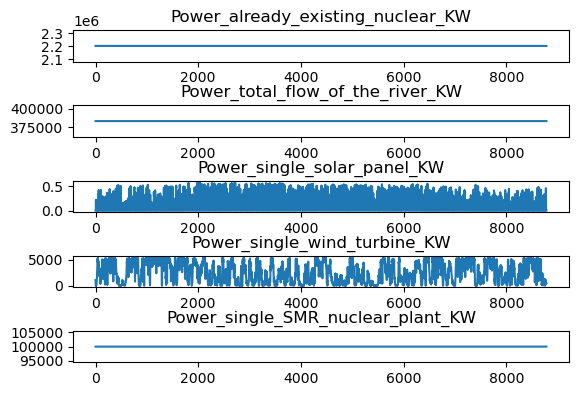

In [2]:
#from excels to numpy arrays

Power_total_demand_KW             = pd.read_excel('Power_total_demand_KW.xlsx').to_numpy()

Power_already_existing_nuclear_KW = pd.read_excel('Power_already_existing_nuclear_KW.xlsx').to_numpy()
Power_total_flow_of_the_river_KW  = pd.read_excel('Power_total_flow_of_the_river_KW.xlsx').to_numpy()

Power_single_solar_panel_KW       = pd.read_excel('Power_single_solar_panel_KW.xlsx').to_numpy()
Power_single_wind_turbine_KW      = pd.read_excel('Power_single_wind_turbine_KW.xlsx').to_numpy()
Power_single_SMR_nuclear_plant_KW = pd.read_excel('Power_single_SMR_nuclear_plant_KW.xlsx').to_numpy()

#debugging
print (Power_already_existing_nuclear_KW.size)
print (Power_total_flow_of_the_river_KW.size)
print (Power_single_solar_panel_KW.size)
print (Power_single_wind_turbine_KW.size)
print (Power_single_SMR_nuclear_plant_KW.size)

figure=plt.figure()

figure.add_subplot(10,1,1).title.set_text('Power_already_existing_nuclear_KW')
plt.plot(Power_already_existing_nuclear_KW)

figure.add_subplot(10,1,3).title.set_text('Power_total_flow_of_the_river_KW')
plt.plot(Power_total_flow_of_the_river_KW) 

figure.add_subplot(10,1,5).title.set_text('Power_single_solar_panel_KW')
plt.plot(Power_single_solar_panel_KW) 

figure.add_subplot(10,1,7).title.set_text('Power_single_wind_turbine_KW')
plt.plot(Power_single_wind_turbine_KW) 

figure.add_subplot(10,1,9).title.set_text('Power_single_SMR_nuclear_plant_KW')
plt.plot(Power_single_SMR_nuclear_plant_KW) 



In [3]:
# simple multiplications, returning total power generation of birmingam 
# for specific number of nuclear ,wind ,and solar plants, except the fucking water storage thing
def powerGeneration(N_nuclearSMR_plants,N_wind_turbines,N_solar_panels):

    power_generated_result=                                                       \
        +N_nuclearSMR_plants * Power_single_SMR_nuclear_plant_KW                  \
        +N_wind_turbines     * Power_single_wind_turbine_KW                       \
        +N_solar_panels      * Power_single_solar_panel_KW                        \
        +Power_already_existing_nuclear_KW                                        \
        +Power_total_flow_of_the_river_KW;
    
    return power_generated_result;

In [4]:
# from demand and generation calculate the power generation of the water storage
    ## Hydro storage power plant 
    # This is a pumped-storage plant, with one upper and one lower reservoir. Water is supplied to the 
    # hydraulic machine (used as a turbine) during peak-hours (high electric demand) and is pumped 
    # during off-peak hours (minimum demand). 
    
upper_reservoir_capacity=1.3e7;                              #[m3]
initial_upper_reservoir_level=upper_reservoir_capacity*0.5;  #[m3]
lower_reservoir_capacity=2.28e7;                             #[m3]
average_head_H=762.5;                                        #[m]
    
    # Power plant equipped with 3 groups of turbopumps: Each group works as a 
    # turbine/generator when generating electricity and as an electricity consumer motor/pump 
    # for pumping water into the upper reservoir. 
    
displacement_pump=8.67*60*60;     #[m3/h group]
displacement_turbine=10*60*60;    #[m3/h group]

power_hydro_pump=75.67e3;         #[Kw/group]
power_hydro_turbine=67.3e3;       #[Kw/group]
    
water_reservoir_level=np.ones((Power_already_existing_nuclear_KW.size, 1));
water_reservoir_level[0]=initial_upper_reservoir_level;

def update_powerGeneration_added_water_from_storage(generation ,demand ,water_reservoir_level):
    reservoir_generation=np.zeros(Power_already_existing_nuclear_KW.size);
    for i in range(1, demand.size): #loop trough each hour of the year (starting on the second hour)
        power_balance = generation[i] - demand[i];
        
        if power_balance > 0:    #excess of energy in the mix
            n_pumps=howmany_pumps_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] +  n_pumps*displacement_pump; #adding water 
            reservoir_generation[i]-= n_pumps*power_hydro_pump                                            #removing power
            
        elif power_balance < 0:  #lack of energy in the mix
            n_turbines=howmany_turbines_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] - n_turbines*displacement_turbine;#removing water 
            reservoir_generation[i]+= n_turbines*power_hydro_turbine                                          #ading power
            
        elif power_balance == 0: #mix is balanced
            water_reservoir_level[i]=water_reservoir_level[i-1];

    return generation;

In [5]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

In [6]:
#calculate how many pumps do we need to activate to consume the right ammount of power (maximum 3)
def howmany_pumps_should_we_turn_on( excess_power_ammount ,previous_water_level):

    if previous_water_level < upper_reservoir_capacity:
        numberofpumps=max((excess_power_ammount/power_hydro_pump),3);
    else :
        #there is no water to empty
        numberofpumps=0;
        
    return numberofpumps;

In [7]:
#calculate how many turbines do we need to activate to produce the right ammount of power (maximum 3)
def howmany_turbines_should_we_turn_on( lack_of_power_ammount ,previous_water_level):

    if previous_water_level >0:
        numberofturbines=clamp(np.floor(-lack_of_power_ammount/power_hydro_turbine),0,3);
    else :
        #there is no room for more water
        numberofturbines=0;
    return numberofturbines;

In [8]:
# total power mix of birmingam to optimice
def calculateGas(numbers_of_things):
    N_nuclearSMR_plants=numbers_of_things[0];
    N_wind_turbines=numbers_of_things[1];
    N_solar_panels=numbers_of_things[2];
    
    generation = powerGeneration( N_nuclearSMR_plants, N_wind_turbines, N_solar_panels);
    
    generation = update_powerGeneration_added_water_from_storage( generation, Power_total_demand_KW, water_reservoir_level);
    
    power_mix_result=generation-Power_total_demand_KW;
    
    gas=(np.clip(-power_mix_result,0,10e9))
    
    np.sum(gas)
    
    return (np.sum(gas));

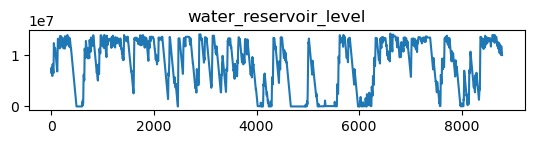

In [9]:
resultado=calculateGas([48, 754, 801666])


figure=plt.figure()

figure.add_subplot(4,1,1).title.set_text('water_reservoir_level')
plt.plot(water_reservoir_level)


In [ ]:
#we have to declare the variables and make the function calc3 
#
#https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

from skopt import gp_minimize

res = gp_minimize(calculateGas,                  # the function to minimize
                  [(30,10e2), (0,10e4)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=150,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed


from skopt.plots import plot_convergence
plot_convergence(res);

In [ ]:
print(res)